In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cd "/content/gdrive/MyDrive/research/"

In [3]:
!pip install torchmetrics einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint

from tensorflow.keras.layers import Conv2D, AvgPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

import torch
from torchvision import transforms

In [27]:
from torch.utils.data import Dataset

# Define the paths to your dataset's train, validation, and test folders
train_path = '/content/gdrive/MyDrive/research/SUIM_DATASET_FINAL/TRAIN'
valid_path = '/content/gdrive/MyDrive/research/SUIM_DATASET_FINAL/VAL'
test_path = '/content/gdrive/MyDrive/research/SUIM_DATASET_FINAL/TEST'

# Define the desired dimensions for resizing the images and masks
height = 128
width = 128

mean = [0.5, 0.5, 0.5]  # RGB mean values
std = [0.5, 0.5, 0.5]   # RGB standard deviation values

#image transform
image_transform = transforms.Compose([
    transforms.Resize((height, width)),  # Resize the images to a fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

#mask transform
mask_transform = transforms.Compose([
    transforms.Resize((height, width)),  # Resize the images to a fixed size
    transforms.ToTensor(),
    transforms.Grayscale(),
])

class SUIMDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None,mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

        for i in self.images:
          if "(" in i or ")" in i:
            self.images.remove(i)

        for i in self.images:
          if "(" in i or ")" in i:
            self.images.remove(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".bmp"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        mask[mask!=0]=1
        mask = mask.view(height,width)

        return image, mask

In [28]:
#Creating the dataset
tr_img_path = train_path+"/train_images"
tr_mask_path = train_path+"/train_mask"

vl_img_path = valid_path+"/val_images"
vl_mask_path = valid_path+"/val_mask"

ts_img_path = test_path+"/test_images"
ts_mask_path = test_path+"/test_mask"

train_dataset = SUIMDataset(tr_img_path,tr_mask_path,image_transform,mask_transform)
valid_dataset = SUIMDataset(vl_img_path,vl_mask_path,image_transform,mask_transform)
test_dataset = SUIMDataset(ts_img_path,ts_mask_path,image_transform,mask_transform)

In [29]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

3148
796
110


In [32]:
# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

# **Data Sample**

torch.Size([4, 3, 128, 128])
torch.Size([4, 128, 128])
tensor([0., 1.])


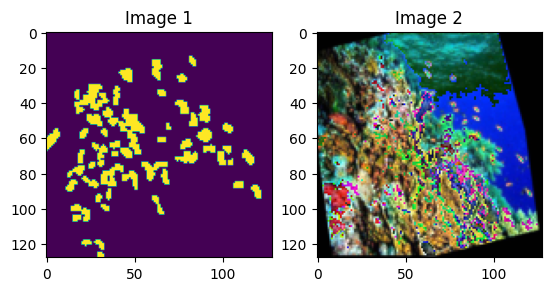

In [33]:
#Sample of the dataset
for inputs,labels in train_loader:
  print(inputs.shape)
  print(labels.shape)

  print(torch.unique(labels[0]))

  to_pil = transforms.ToPILImage()
  image1 = to_pil(labels[0])

  image2 = to_pil(inputs[0])

  # Create a figure
  fig = plt.figure()

  # Add subplots for the two images
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)

  # Plot the images
  ax1.imshow(image1)
  ax2.imshow(image2)

  # Add titles to the subplots
  ax1.set_title("Image 1")
  ax2.set_title("Image 2")

  # Show the figure
  plt.show()
  break

# **Model**

In [34]:
import math
import torch
import torch.nn as nn
from einops import rearrange
from torchvision.models import resnet50

class PatchPartition(nn.Module):
    def __init__(self, patch_size):
        super(PatchPartition, self).__init__()
        self.patch_size = patch_size

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        patch_height = height // self.patch_size
        patch_width = width // self.patch_size

        # Reshape input into patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
        patches = patches.view(batch_size, patch_height * patch_width, -1)

        #print(patches.shape,"pp")
        return patches

class LinearEmbedding(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearEmbedding, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim

    def forward(self, x):
        # x: (batch_size, patch_height * patch_width, patch_size * patch_size * channels)
        batch_size, input_channels, num_patches = x.size()

        x = self.linear(x)
        x = x.view(batch_size,-1,self.output_dim)

        #print(x.shape,"le")

        return x


class SwinTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio,v):
        super(SwinTransformerBlock, self).__init__()
        self.embed_dim = v*embed_dim
        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(self.embed_dim)
        self.self_attention = nn.MultiheadAttention(self.embed_dim, num_heads, dropout=0.1,batch_first=True)
        self.norm2 = nn.LayerNorm(self.embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(self.embed_dim, int(self.embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(self.embed_dim * mlp_ratio), self.embed_dim)
        )

    def forward(self, x):
        # x: (batch_size, patch_width * patch_height, embed_dim)
        residual = x

        x = self.norm1(x)
        x, _ = self.self_attention(x, x, x)

        x += residual
        residual = x

        x = self.norm2(x)
        x = self.mlp(x)

        x += residual

        #print(x.shape,"sw")
        return x


# Patch Merging
class PatchMerging(nn.Module):
    def __init__(self, embed_dim,v): #input_dim is embed_dim
        super(PatchMerging, self).__init__()
        self.linear = nn.Linear((v*embed_dim),((v*embed_dim)//2))

    def forward(self, x):

      batch_size, num_patches, embed_dim = x.size()

      stride = 2
      new_height = int(math.sqrt(num_patches)) // stride
      new_width = int(math.sqrt(num_patches)) // stride

      patches = x.view(batch_size,embed_dim, new_height, stride, new_width, stride)

      # Permute the dimensions to bring stride dimensions next to each other
      patches = patches.permute(0, 1, 3, 5, 2, 4)

      # Reshape and concatenate the patches to obtain the merged output
      merged = patches.contiguous().view(batch_size,embed_dim*(stride ** 2), new_height, new_width)
      merged = merged.view(batch_size,new_height*new_width,-1)

      #print(merged.shape,"pm")

      batch_size, num_patches, embed_dim = merged.size()

      merged = self.linear(merged)

      #print(merged.shape,"pm-le")

      return merged

class PatchExpanding(nn.Module):
    def __init__(self, embed_dim,v):
        super(PatchExpanding, self).__init__()
        self.linear = nn.Linear(((v*embed_dim)//2),(v*embed_dim))

    def forward(self, x):
      batch_size, num_patches, embed_dim = x.size()
      x = self.linear(x)

      #print(x.shape,"pE-le")

      batch_size, num_patches, embed_dim = x.size()

      stride = 2
      new_height = int(math.sqrt(num_patches)) * stride
      new_width = int(math.sqrt(num_patches)) * stride

      patches = x.view(batch_size,embed_dim//(stride**4), new_height, stride, new_width, stride)

      # Permute the dimensions to bring stride dimensions next to each other
      patches = patches.permute(0, 1, 3, 5, 2, 4)

      patches = patches.contiguous().view(batch_size,(embed_dim//(stride ** 2)), new_height, new_width)
      patch_expanded = patches.view(batch_size,new_height*new_width,-1)

      #print(patch_expanded.shape,"pE")

      return patch_expanded

class PatchExpander(nn.Module):
    def __init__(self, embed_dim,v):
        super(PatchExpander, self).__init__()
        self.linear = nn.Linear((embed_dim//v),(embed_dim//(v*2)))

    def forward(self, x):
      batch_size, num_patches, embed_dim = x.size()

      stride = 4
      new_height = int(math.sqrt(num_patches)) * stride
      new_width = int(math.sqrt(num_patches)) * stride

      patches = x.view(batch_size,embed_dim//(stride**2), new_height//stride, stride, new_width//stride, stride)

      # Permute the dimensions to bring stride dimensions next to each other
      patches = patches.permute(0, 1, 3, 5, 2, 4)

      patches = patches.contiguous().view(batch_size,(embed_dim//(stride ** 2)), new_height, new_width)
      patch_expanded = patches.view(batch_size,new_height*new_width,-1)

      #print(patch_expanded.shape,"pE")

      batch_size, num_patches, embed_dim = patch_expanded.size()
      patch_expanded = self.linear(patch_expanded)

      #print(patch_expanded.shape,"pE-le")

      return patch_expanded

In [35]:
class SwinConvMixerUNet(nn.Module):
    def __init__(self, input_channels, num_classes, embed_dim=64, num_heads=4, mlp_ratio=4, kernel_size=3, patch_size=4):
        super(SwinConvMixerUNet, self).__init__()

        self.patch_partition = PatchPartition(patch_size)

        feature_dimension = (patch_size ** 2 * input_channels) # Calculate feature_dimension

        self.linear_embedding = LinearEmbedding(feature_dimension, embed_dim)  # Pass feature_dimension as input_dim

        self.swin_transformer_block_1 = SwinTransformerBlock(embed_dim, num_heads, mlp_ratio,1)
        self.swin_transformer_block_2 = SwinTransformerBlock(embed_dim, num_heads, mlp_ratio,2)
        self.swin_transformer_block_3 = SwinTransformerBlock(embed_dim, num_heads, mlp_ratio,4)
        self.swin_transformer_block_4 = SwinTransformerBlock(embed_dim, num_heads, mlp_ratio,8)

        self.patch_merging_1 = PatchMerging(embed_dim,4)
        self.patch_merging_2 = PatchMerging(embed_dim,8)
        self.patch_merging_3 = PatchMerging(embed_dim,16)

        self.patch_expanding_1 = PatchExpanding(embed_dim,16)
        self.patch_expanding_2 = PatchExpanding(embed_dim,8)
        self.patch_expanding_3 = PatchExpanding(embed_dim,4)
        self.patch_expanding_4 = PatchExpander(embed_dim,16)

        self.encoder = nn.Sequential(
            self.patch_partition,
            self.linear_embedding,
            self.swin_transformer_block_1,
            self.swin_transformer_block_1,
            self.patch_merging_1,
            self.swin_transformer_block_2,
            self.swin_transformer_block_2,
            self.patch_merging_2,
            self.swin_transformer_block_3,
            self.swin_transformer_block_3,
            self.patch_merging_3,
            self.swin_transformer_block_4,
            self.swin_transformer_block_4
        )

        self.decoder = nn.Sequential(
          self.patch_expanding_1,
          self.swin_transformer_block_3,
          self.swin_transformer_block_3,
          self.patch_expanding_2,
          self.swin_transformer_block_2,
          self.swin_transformer_block_2,
          self.patch_expanding_3,
          self.swin_transformer_block_1,
          self.swin_transformer_block_1,
          self.patch_expanding_4
        )

    def forward(self, x):
        # x: (batch_size, input_channels, height, width)
        patches = self.encoder(x)

        #print(patches.shape,"After Encoder")

        output = self.decoder(patches)
        output = output.permute(0,2,1)
        output = output.view(-1,2,128,128)

        return output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchmetrics
import time

start_time = time.time()

# Initialize the model
input_channels = 3
num_classes = 2
model = SwinConvMixerUNet(input_channels, num_classes)

learning_rate = 0.001
num_epochs = 350

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
MIOU = torchmetrics.JaccardIndex(num_classes=2,task="multiclass")

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
MIOU.to(device)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    miou_epoch = 0
    count=0

    # Iterate over the training dataset
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        miou = MIOU(outputs,labels)
        print("mIoU:", miou)
        miou_epoch += miou

#        print(outputs.shape,labels.shape)
        # Compute the loss
        labels = labels.to(torch.int64)
        loss = criterion(outputs, labels)
        loss = loss.to(device)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss for monitoring
        running_loss += loss.item()

        count+=1

    break
    # Print the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, MIOU: {miou_epoch/count}")

end_time = time.time()
running_time = end_time - start_time
print("Time -----  ",running_time)

mIoU: tensor(0.5012, device='cuda:0')
tensor([0., 1.])


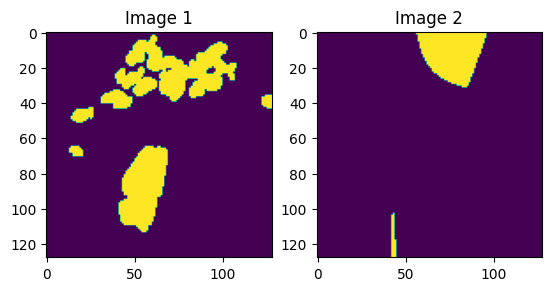

In [ ]:
# Iterate over the training dataset
for inputs, labels in valid_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)

    miou = MIOU(outputs,labels)
    print("mIoU:", miou)

    zbc = np.zeros((128, 128))
    zbc = zbc.astype(np.float32)

    for i in range(128):
      for j in range(128):
        if(outputs[0][0][i][j]<=outputs[0][1][i][j]):
          zbc[i][j]=1

    zbc = torch.from_numpy(zbc)
    print(torch.unique(zbc))

    to_pil = transforms.ToPILImage()
    image1 = to_pil(labels[0])
    image2 = to_pil(zbc)

    # Create a figure
    fig = plt.figure()

    # Add subplots for the two images
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Plot the images
    ax1.imshow(image1)
    ax2.imshow(image2)

    # Add titles to the subplots
    ax1.set_title("Image 1")
    ax2.set_title("Image 2")

    # Show the figure
    plt.show()
    break

In [ ]:
torch.save(model.state_dict, '/content/gdrive/My Drive/research/model1.pt')

In [ ]:
import torch

model_path = "/content/gdrive/My Drive/research/model.pt"
model = torch.load(model_path)
print(model)

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)